In [1]:
from data import series_data
from importlib import import_module
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from util import train, plot_confusion_matrix, plot_loss_accuracy, plot_dataloader_distribution

/home/giulia/SaltAndPepper/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'Casilino'
model_name = 'FullyConnectedNetwork'
rearrange_tensor = False
units = 100
layers = 3
batch = 200
epochs = 20
device = 'cpu'

In [11]:
dataset = import_module('datasets.' + dataset_name)
model = getattr(import_module('model'), model_name)
ts, labels = dataset.load_data()
if rearrange_tensor:
    ts = ts.transpose(1, 2)
n_labels = int(labels.max()) + 1
label_names = dataset.get_label_names()
data = series_data.Series(ts, labels, {'RandomScaling':[1,0.1,1.8],'RandomAmplitudeFlip':[1]})
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)
net = model(num_classes=n_labels, input_len=ts.size(2), 
                            hidden_units=units, hidden_layers=layers).to(device)
print(f'The number of samples for training is {train_size}.')
class_samples = [int(sum(labels==l))/len(labels) for l in range(n_labels)]
print(f'Samples per classes: {class_samples}')
class_samples_train = [sum([int(t[1])==l for t in list(train_data)])/len(list(train_data)) for l in range(n_labels)]
print(f'Samples per classes (training): {class_samples_train}')
class_samples_valid = [sum([int(v[1])==l for v in list(valid_data)])/len(list(valid_data)) for l in range(n_labels)]
print(f'Samples per classes (validation): {class_samples_valid}')
print(f'The number of parameters is {sum(p.numel() for p in net.parameters())}.')


Dataset already assembled in /home/giulia/Documenti/ecgproject/datasets/Casilino.
Dataset already assembled in /home/giulia/Documenti/ecgproject/datasets/Casilino.
The number of samples for training is 8.
Samples per classes: [0.6, 0.4]
Samples per classes (training): [0.625, 0.375]
Samples per classes (validation): [0.5, 0.5]
The number of parameters is 1520502.


In [12]:
ts_squeezed= ts.squeeze(1)
indice=6
patient=ts[indice,:].squeeze(0)
patient_n=patient.numpy()
print(patient_n[0:50])
print(labels)

[0.31559214 0.31559214 0.31559214 0.31559214 0.31559214 0.31559214
 0.31559214 0.31559214 0.31559214 0.31559214 0.31560177 0.31559214
 0.31552473 0.31540918 0.31529358 0.31520692 0.31516838 0.31516838
 0.31518763 0.3151973  0.31520692 0.3151973  0.31502393 0.31458086
 0.31461942 0.31429195 0.31383926 0.315178   0.29986453 0.2416445
 0.15294199 0.0712124  0.01768271 0.         0.         0.00072233
 0.00457478 0.00421843 0.00282191 0.00217663 0.00256187 0.00342867
 0.00361167 0.00264855 0.00191659 0.00337089 0.00574977 0.00577867
 0.00368871 0.0027545 ]
tensor([0, 1, 0, 1, 0, 0, 0, 0, 1, 1])


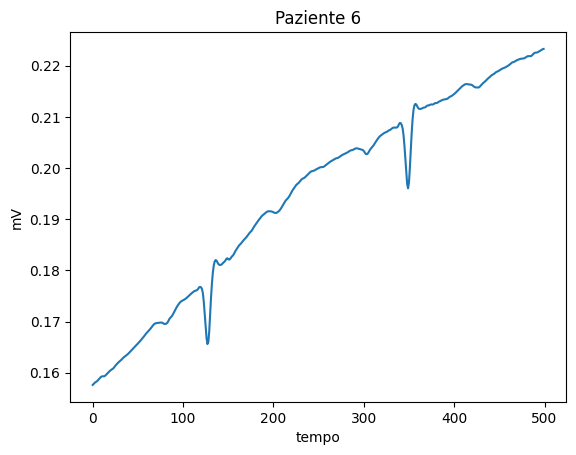

In [13]:
import matplotlib.pyplot as plt 
import numpy as np 
tempo=np.arange(500)
#ecg,ax=plt.subplot()
plt.plot(tempo,patient_n[1000:1500])
plt.xlabel('tempo')
plt.ylabel('mV')
plt.title('Paziente %i' %indice)
plt.show()

(15000,)


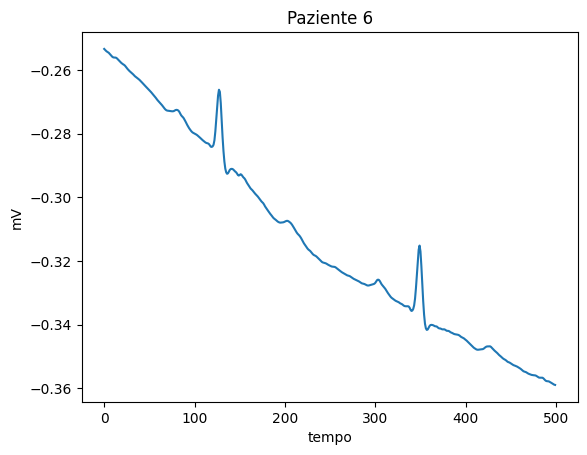

In [14]:
d= data.__getitem__(6)[0][0].numpy()
print(d.shape)
plt.plot(tempo,d[1000:1500])
plt.xlabel('tempo')
plt.ylabel('mV')
plt.title('Paziente %i' %indice)
plt.show()